# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Process/Issues
- Double-checked that the images we were given were correctly bounded (did this by visualizing the boxes on the images - they look good!)
- Complication: Originally when I creating augmented images, the bounding box labels did not also augment. I also had to try out a few types of augmentation to see what made sense for waldo. The augmented images may still not be as different from one another as they could be which could allow the model to favor the training images that occur more frequently.
- Complication: Similarly, when resizing the images, ensuring the bounding boxes not only are also adjusted if necessary, but ensuring they do not get cut off and the image is not stretched/shrunk too much.
- Tried Yolo architecture first but produced too many boxes and did not work well. Tried faster rcnn architecture next and the inputs and outputs and processing steps for each were very different which was frustrating

### Imports

In [14]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image


#from torchvision.io import read_image
#from tqdm import tqdm
#import cv2
#import albumentations as A
#from torchvision.transforms import functional as Fu
#from torch.utils.data import DataLoader, Dataset

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("mps")
print(device)

mps


### Download Data

In [15]:
od.download('https://www.kaggle.com/competitions/2024-fall-ml-3-hw-4-wheres-waldo/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading 2024-fall-ml-3-hw-4-wheres-waldo.zip to ./2024-fall-ml-3-hw-4-wheres-waldo


100%|██████████| 38.2M/38.2M [00:01<00:00, 32.3MB/s]



Extracting archive ./2024-fall-ml-3-hw-4-wheres-waldo/2024-fall-ml-3-hw-4-wheres-waldo.zip to ./2024-fall-ml-3-hw-4-wheres-waldo


### Paths

In [3]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File

# Preprocessing

In [6]:
# Split training data into train and validation sets
annotations = pd.read_csv(annotations_file)
image_files = annotations["filename"].unique()
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

def filter_csv_by_column(input_csv, output_csv, column_name, values_list):

    # Load the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # Filter the DataFrame
    filtered_df = df[df[column_name].isin(values_list)]

    # Save the filtered DataFrame to a new CSV file
    filtered_df.to_csv(output_csv, index=False)

#Train Annotations
values_list = list(train_images)
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv"  # Replace with your output file path
column_name = "filename"  # Replace with the column you want to filter
filter_csv_by_column(annotations_file, output_csv, column_name, values_list)

#Test Annotations
values_list = list(val_images)
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv"  # Replace with your output file path
column_name = "filename"  # Replace with the column you want to filter
filter_csv_by_column(annotations_file, output_csv, column_name, values_list)

#Train/Test Split (80/20)
def split_directory(source_dir, target_dir, file_list):
    """Splits files from source_dir to target_dir based on file_list."""

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(target_dir, file_name)

        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            print(f"Moved: {file_name}")
        else:
            print(f"File not found: {file_name}")

if __name__ == "__main__":
    source_dir = train_folder
    target_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/val"
    file_list = list(val_images)

    split_directory(source_dir, target_dir, file_list)

Moved: 18.jpg
Moved: 5.jpg
Moved: 19.jpg
Moved: 22.jpg
Moved: 1.jpg
Moved: 3.jpg


In [7]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 4:8].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/train",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor()
    ])
)

val_dataset = WaldoDataset(
    annotations_file="2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor()
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))  # Fix the collate_fn to return a list of images and targets
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))  # Same here for validation
)


# Model

### Architecture

In [8]:
# Define the model
class SimpleBBoxModel(nn.Module):
    def __init__(self):
        super(SimpleBBoxModel, self).__init__()
        # Define a simple CNN architecture
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define a fully connected layer to output 4 values for the bounding box
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Flattening 64 channels of 16x16 feature maps
        self.fc2 = nn.Linear(128, 4)  # Outputting the 4 bounding box coordinates

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Pooling to reduce the spatial dimensions
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Pooling again
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)  # Final pooling
        
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        bbox = self.fc2(x)  # Output 4 values for the bounding box
        
        return bbox

# Example usage:
model = SimpleBBoxModel()

# Input a batch of 128x128 RGB images (batch_size=2)
images = torch.randn(2, 3, 128, 128)  # Random images for demonstration

# Forward pass
output = model(images)
print("Bounding box predictions: ", output)


Bounding box predictions:  tensor([[0.0096, 0.0707, 0.0660, 0.0911],
        [0.0207, 0.0816, 0.0805, 0.0981]], grad_fn=<AddmmBackward0>)


### Training

In [11]:
# Set up the model, loss, and optimizer
model = SimpleBBoxModel()#.to(device)
criterion = nn.L1Loss()  # L1 loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_data_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets in train_data_loader:
            #images = images.to(device)
            #targets = targets.to(device)
            # Unzip the targets
            target_boxes = [target["boxes"] for target in targets]  # Extract bounding boxes
            
            # Convert the list of bounding boxes to a tensor
            target_boxes = torch.stack(target_boxes)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_data_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation loop
def evaluate(model, val_data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in val_data_loader:
            #images = images.to(device)
            #targets = targets.to(device)
            target_boxes = [target["boxes"] for target in targets]
            target_boxes = torch.stack(target_boxes)

            # Forward pass
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_data_loader)
    print(f"Evaluation Loss: {avg_loss:.4f}")


# Train the model
train(model, train_data_loader, criterion, optimizer, num_epochs=20)

# Evaluate the model
evaluate(model, val_data_loader, criterion)


Epoch 1/20, Loss: 516.1397
Epoch 2/20, Loss: 435.8456
Epoch 3/20, Loss: 367.8757
Epoch 4/20, Loss: 357.5320
Epoch 5/20, Loss: 371.8441
Epoch 6/20, Loss: 354.3347
Epoch 7/20, Loss: 354.5881
Epoch 8/20, Loss: 354.0828
Epoch 9/20, Loss: 356.1727
Epoch 10/20, Loss: 352.1968
Epoch 11/20, Loss: 349.9612
Epoch 12/20, Loss: 354.6781
Epoch 13/20, Loss: 355.8367
Epoch 14/20, Loss: 356.8272
Epoch 15/20, Loss: 374.6738
Epoch 16/20, Loss: 356.4157
Epoch 17/20, Loss: 356.3588
Epoch 18/20, Loss: 352.2123
Epoch 19/20, Loss: 356.2970
Epoch 20/20, Loss: 356.8822
Evaluation Loss: 357.5997


# Submission File 

Predicted Bounding Box: [377.5918  222.71515 421.74478 261.57428]


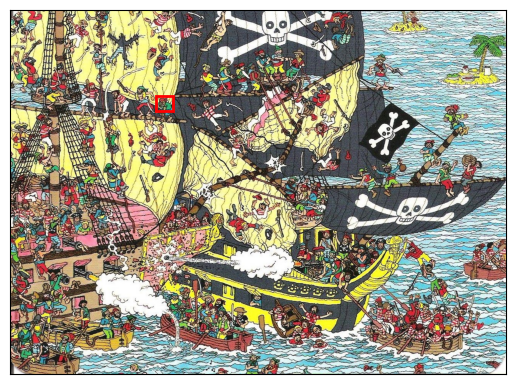

Predicted Bounding Box: [379.92584 224.18996 424.23697 263.14124]


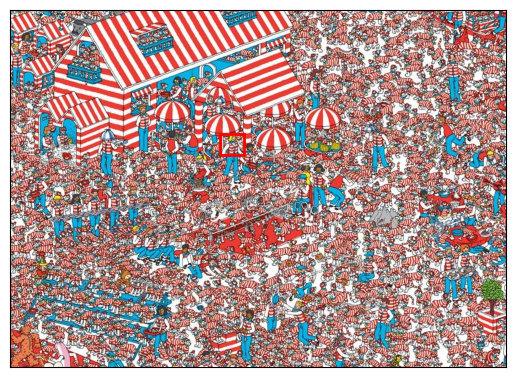

Predicted Bounding Box: [354.24728 209.0343  395.77997 245.6184 ]


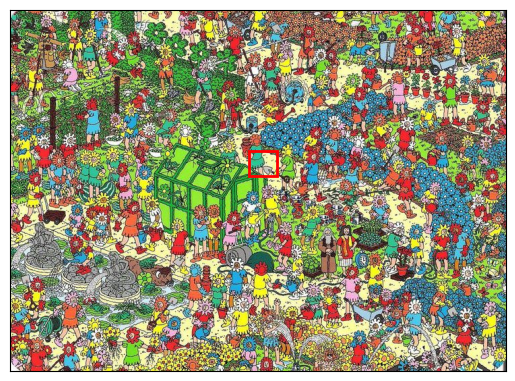

Predicted Bounding Box: [354.7647  209.15979 396.34537 245.79837]


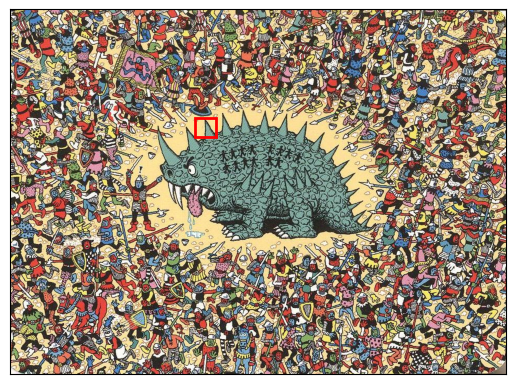

Predicted Bounding Box: [441.28738 260.2406  492.64716 305.91608]


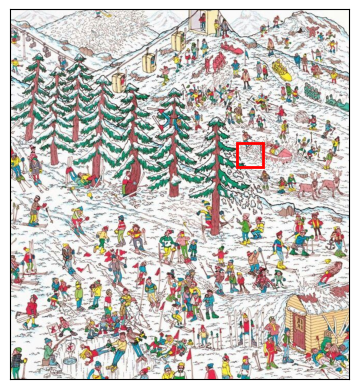

Predicted Bounding Box: [368.71375 217.43419 411.91766 255.5832 ]


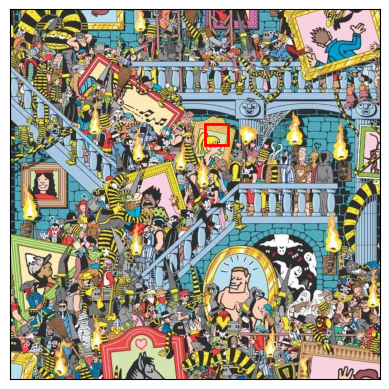

Predicted Bounding Box: [362.45822 213.9539  403.93704 251.44084]


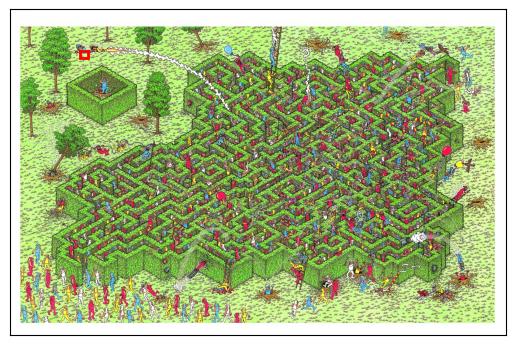

Predicted Bounding Box: [393.79147 232.19774 439.546   272.68756]


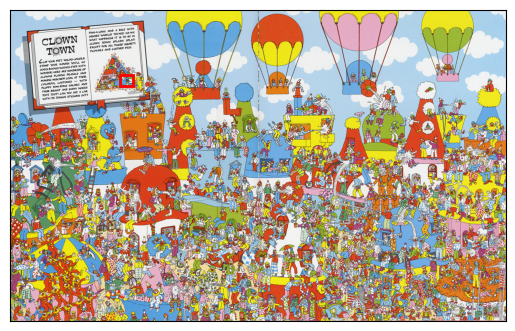

Predicted Bounding Box: [370.8507  218.65918 414.0673  256.99463]


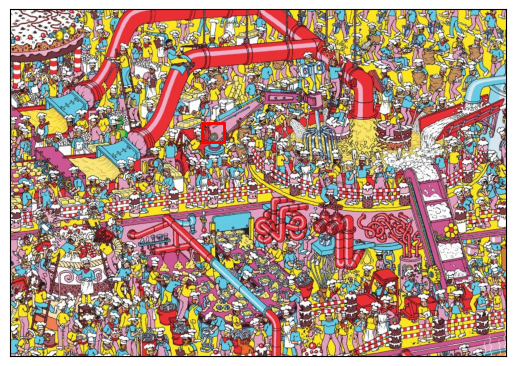

In [13]:
predictions = []

output_directory = "2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    if transform:
        image = transform(image)  # Apply transformations like resizing, normalization
    image = image.unsqueeze(0)  # Add batch dimension (1, 3, 128, 128)

    # Predict the bounding box
    with torch.no_grad():  # No need to calculate gradients during prediction
        predicted_bbox = model(image)  # Get predicted bounding box

    return predicted_bbox.squeeze().cpu().numpy()  # Remove batch dimension and return as numpy array

# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor()  # Convert the image to a tensor
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    # Example usage for prediction on a new image
    image_path = os.path.join(test_folder, name)  # Replace with the path to your test image
    predicted_bbox = predict(model, image_path, transform)

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
